In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data validation

In [3]:
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

it seems all of the data types are good except for servings let's change this to a number, but before we need to check if all the content contains only numbers

In [4]:
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

we have '4 as a snack' and '6 as a snack' we need to change them to 4 and 6

### servings column validation

In [5]:
df['servings'] = df['servings'].str.replace(' as a snack', '')
df['servings'].unique()

array(['6', '4', '1', '2'], dtype=object)

great all now let's change the data type

In [6]:
df['servings'] = df['servings'].astype(int)
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int32
high_traffic     object
dtype: object

### category column validation

In [7]:
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

the Chicken Breast category is the same as 'Chicken'

In [8]:
df['category'] = df['category'].str.replace('Chicken Breast', 'Chicken')
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

### high_traffic column validation

In [9]:
df['high_traffic'].unique()

array(['High', nan], dtype=object)

nan values in high_traffic means not high

In [10]:
df['high_traffic'].fillna('Not-High', inplace=True)

In [11]:
df['high_traffic'].unique()

array(['High', 'Not-High'], dtype=object)

## Missing Values

In [12]:
df.isna().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [13]:
na_cols=df.columns[df.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(df[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(df),2)
mv

,Number_missing,Percentage_missing
calories,52,5.49
carbohydrate,52,5.49
sugar,52,5.49
protein,52,5.49


missing values occupy almost 5.5% of the data

Text(0.5, 1.0, 'Heatmap of missing values')

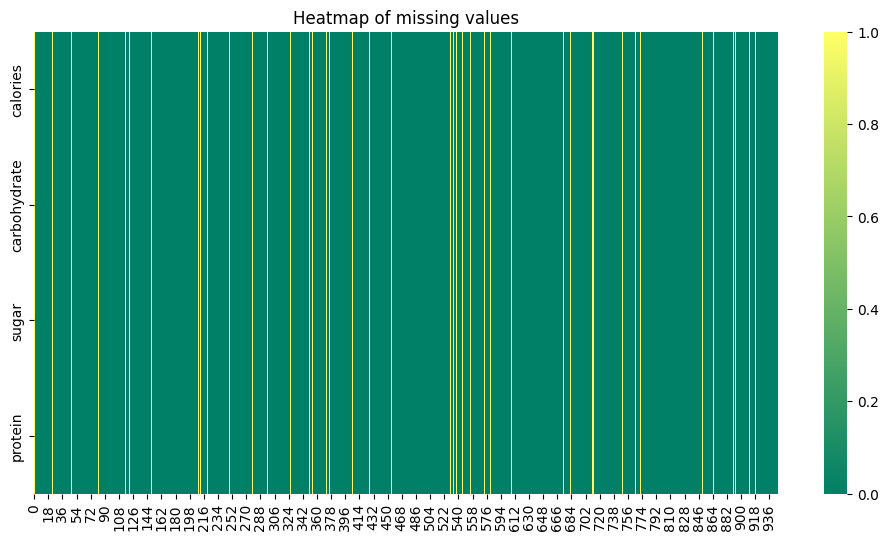

In [14]:
plt.figure(figsize=(12,6))
sns.heatmap(df[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

the missing seems to be happening at the same time, let's find a way to impute this values mean or median, firstly we have to check if there is outliers

In [15]:
def outliers_iqr_count(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return column[(column < lower_bound) | (column > upper_bound)].count()

In [16]:
for na_col in na_cols:
    print(f"{na_col} outliers: {outliers_iqr_count(df[na_col])}")

calories outliers: 47
carbohydrate outliers: 58
sugar outliers: 79
protein outliers: 77


it's preferred to use median over mean in this case, another thing is that we know for sure that the Nutritional Information depends on the category of the serving so instead of filling missing values of general medians let's be more specefic and group by category

In [17]:
imputation_dict = np.round(
    df.groupby('category')[['calories', 'carbohydrate', 'sugar', 'protein']].agg('median'), 2) \
    .to_dict()
imputation_dict

{'calories': {'Beverages': 126.46,
  'Breakfast': 229.38,
  'Chicken': 379.16,
  'Dessert': 288.55,
  'Lunch/Snacks': 369.5,
  'Meat': 460.87,
  'One Dish Meal': 419.28,
  'Pork': 399.26,
  'Potato': 269.46,
  'Vegetable': 124.3},
 'carbohydrate': {'Beverages': 11.25,
  'Breakfast': 28.42,
  'Chicken': 15.49,
  'Dessert': 38.55,
  'Lunch/Snacks': 31.98,
  'Meat': 19.12,
  'One Dish Meal': 25.43,
  'Pork': 19.56,
  'Potato': 32.54,
  'Vegetable': 13.34},
 'sugar': {'Beverages': 8.07,
  'Breakfast': 4.83,
  'Chicken': 3.5,
  'Dessert': 24.65,
  'Lunch/Snacks': 2.75,
  'Meat': 3.38,
  'One Dish Meal': 4.04,
  'Pork': 5.23,
  'Potato': 2.64,
  'Vegetable': 3.7},
 'protein': {'Beverages': 0.41,
  'Breakfast': 11.68,
  'Chicken': 33.17,
  'Dessert': 4.81,
  'Lunch/Snacks': 12.96,
  'Meat': 28.53,
  'One Dish Meal': 28.48,
  'Pork': 29.82,
  'Potato': 5.9,
  'Vegetable': 4.84}}

In [18]:
# for na_col in na_cols:
#     df[na_col].fillna(df['category'].map(imputation_dict[na_col]), inplace=True)
columns = ["calories", "carbohydrate", "sugar", "protein"]
df[columns] = df[columns].fillna(df[columns].median())

In [19]:
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [20]:
df.drop(columns=['recipe'], axis=1, inplace=True)

In [21]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,288.55,21.48,4.55,10.80,Pork,6,High
1,35.48,38.56,0.66,0.92,Potato,4,High
2,914.28,42.68,3.09,2.88,Breakfast,1,Not-High
3,97.03,30.56,38.63,0.02,Beverages,4,High
4,27.05,1.85,0.80,0.53,Beverages,4,Not-High


**SUMMARY :**
After importing the dataframe, we found that there were 52 missing values for nutritional columns (calories, protein, carbohydrates and suger). These missing values are MCAR, since they happened in the same place! We filled missing values by medians grouped by category since the variable had outliers.

* We handled the types of the variables in the dataframe.

* We correct the number of categories by changing chicken breast into chicken.


At the end we have this takeaway for the variables:

* recipe : dropped since we work with default index
* calories : outliers check + fill missing by medians
* carbohydrate : outliers check + fill missing by medians
* sugar : outliers check + fill missing by medians
* protein : outliers check + fill missing by medians
* category : make the changes to have really 10 possible values. Chicken Breast became Chicken.
* servings : cleaning from strings values and conversion to int32 variable.
* high_traffic : including the "Not-High" traffic value to fill the missing data.

# Exploratory Analysis

## Study the high_traffic target variable

<Axes: xlabel='high_traffic', ylabel='count'>

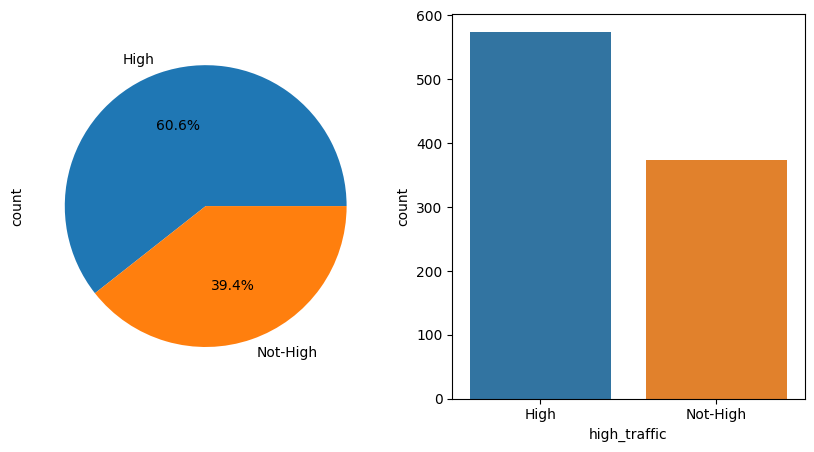

In [22]:
_, ax = plt.subplots(1,2, figsize=(10,5))

df['high_traffic'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
sns.countplot(df, x='high_traffic', ax=ax[1])

the high-traffic recipes occupies over **60%** of the data in contrast the not-high with almost **40%**.
the dataset is not that balanced in this case we need to take that into consideration when splitting the data for modeling, the website has higher high-traffic recipes than the others

## the relation with the target variable

<Axes: xlabel='category', ylabel='count'>

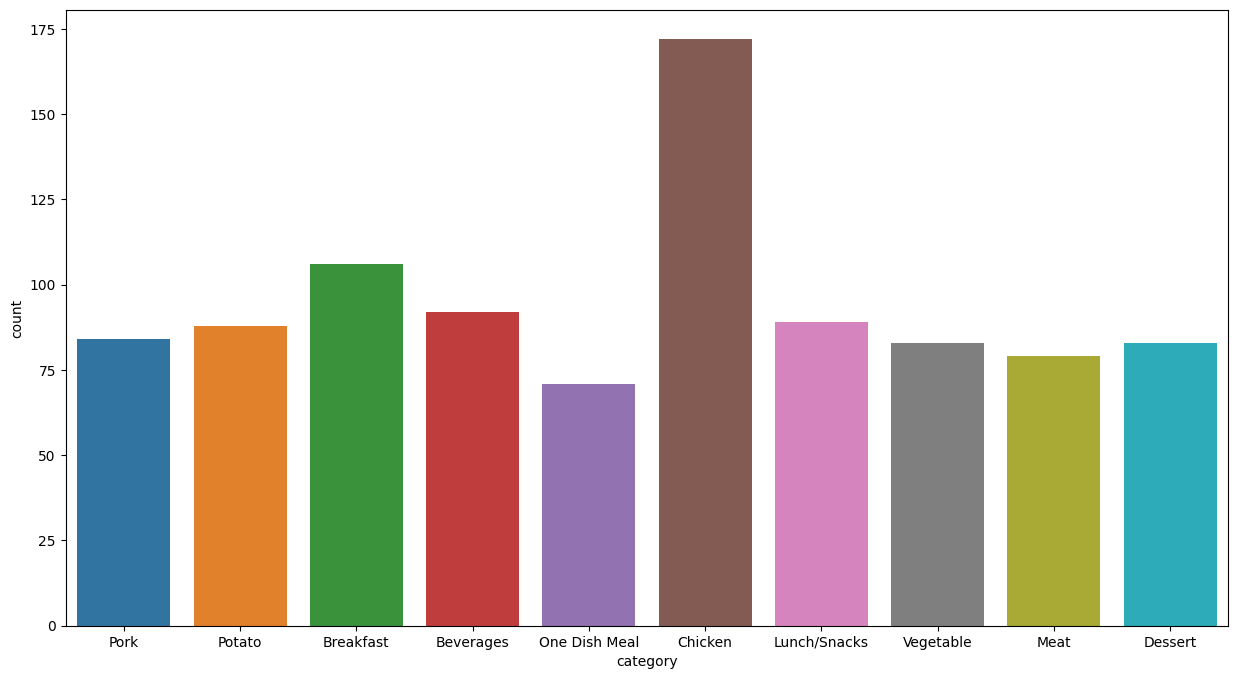

In [23]:
plt.figure(figsize=(15, 8))
sns.countplot(df, x='category')

Interesting, we can see that the categories are quite even except (almost between 75 and 100) for the Chicken category, this gives a clear idea about the distribution of the categories

<Axes: xlabel='category', ylabel='count'>

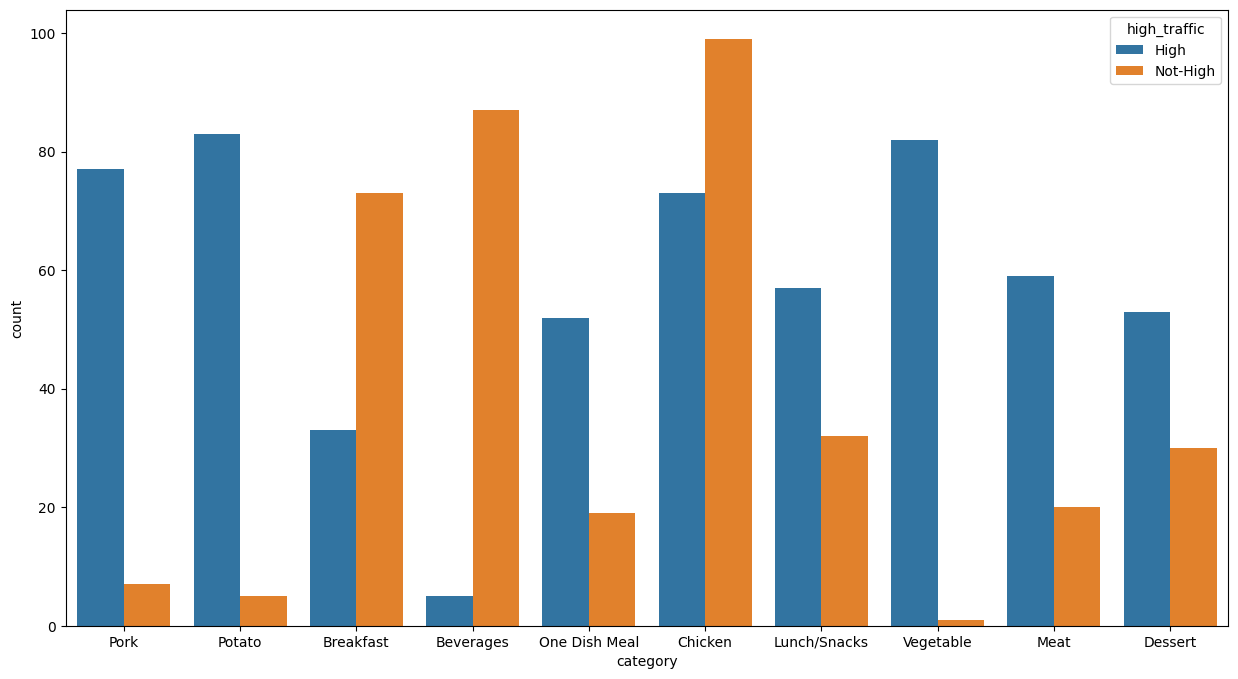

In [24]:
plt.figure(figsize=(15, 8))
sns.countplot(df, x='category', hue='high_traffic')

this gives an idea about the ranking, we can observe that Pork, Potato and Vegetables are popular, whereas Beverages and Breakfast aren't that popular

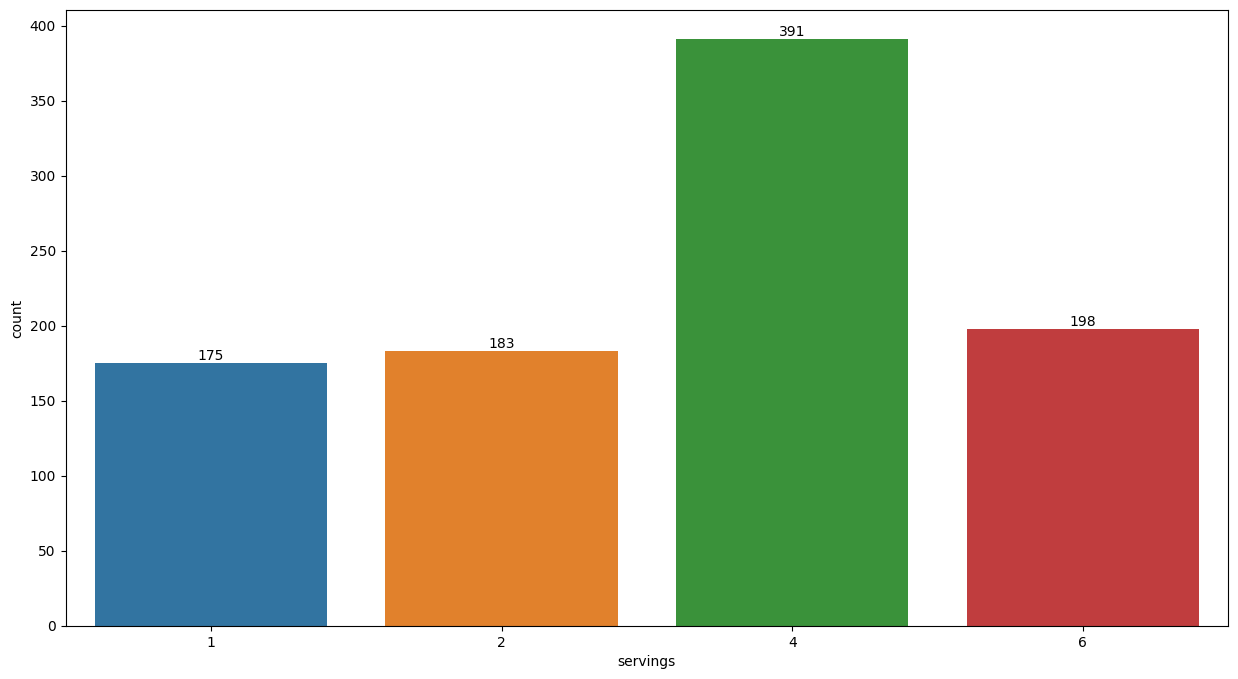

In [25]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(df, x='servings')
for container in ax.containers:
    ax.bar_label(container)

we can see that recipes with 4 servings are more in this dataset and for 1,2 and 6 are the same

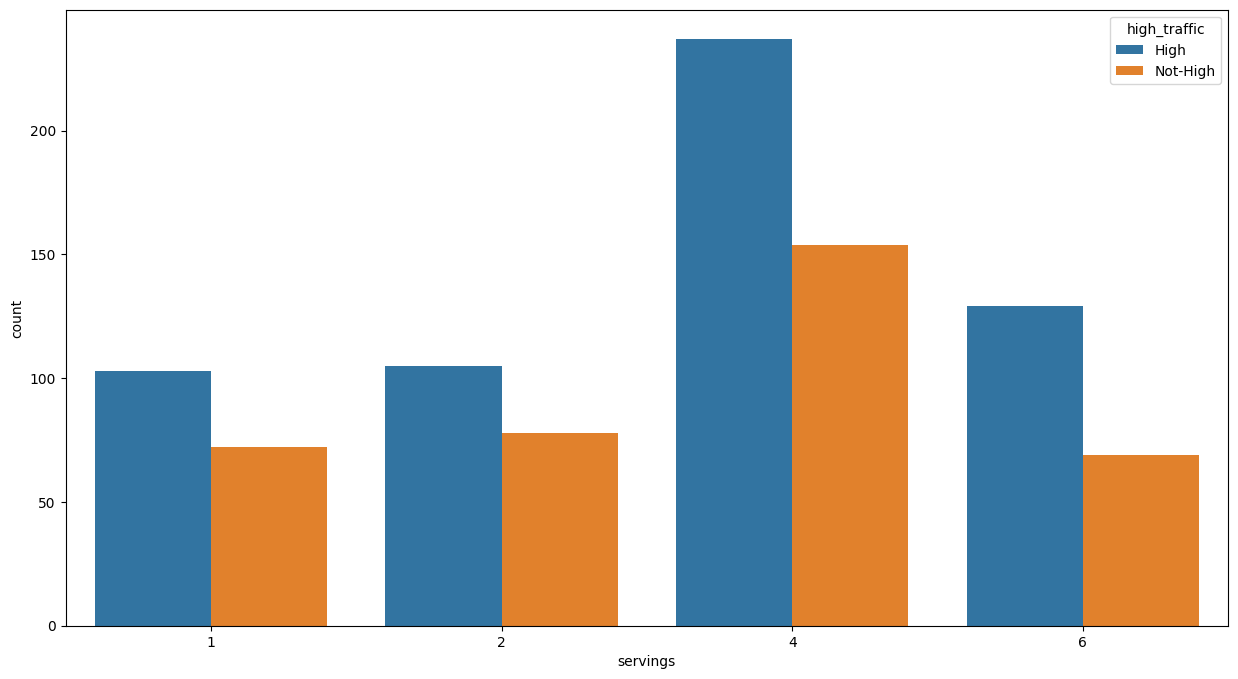

In [26]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(df, x='servings', hue='high_traffic')

it's always for every serving having higher propotion of high-traffic compared to not-high traffic

<Axes: xlabel='servings', ylabel='high_traffic'>

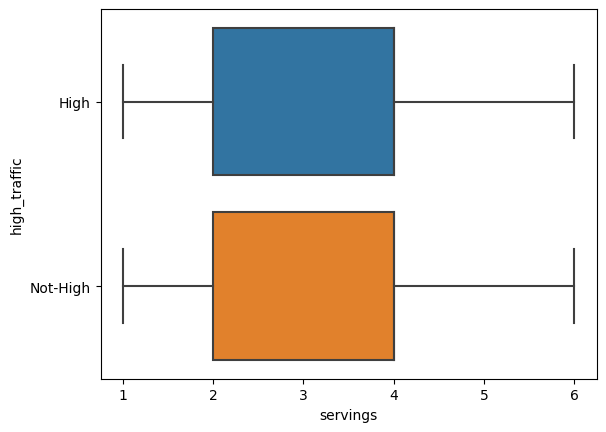

In [27]:
sns.boxplot(df, x='servings', y='high_traffic')

the distribution of the servings doesn't change when we compare the popularity

In [28]:
df.describe()

,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,427.846019,34.323464,8.799641,23.416283,3.477297
std,441.673556,42.836191,14.306785,35.486699,1.732741
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,114.410000,9.135000,1.795000,3.465000,2.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000
75%,576.225000,42.590000,9.285000,28.530000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


<Axes: xlabel='protein', ylabel='Count'>

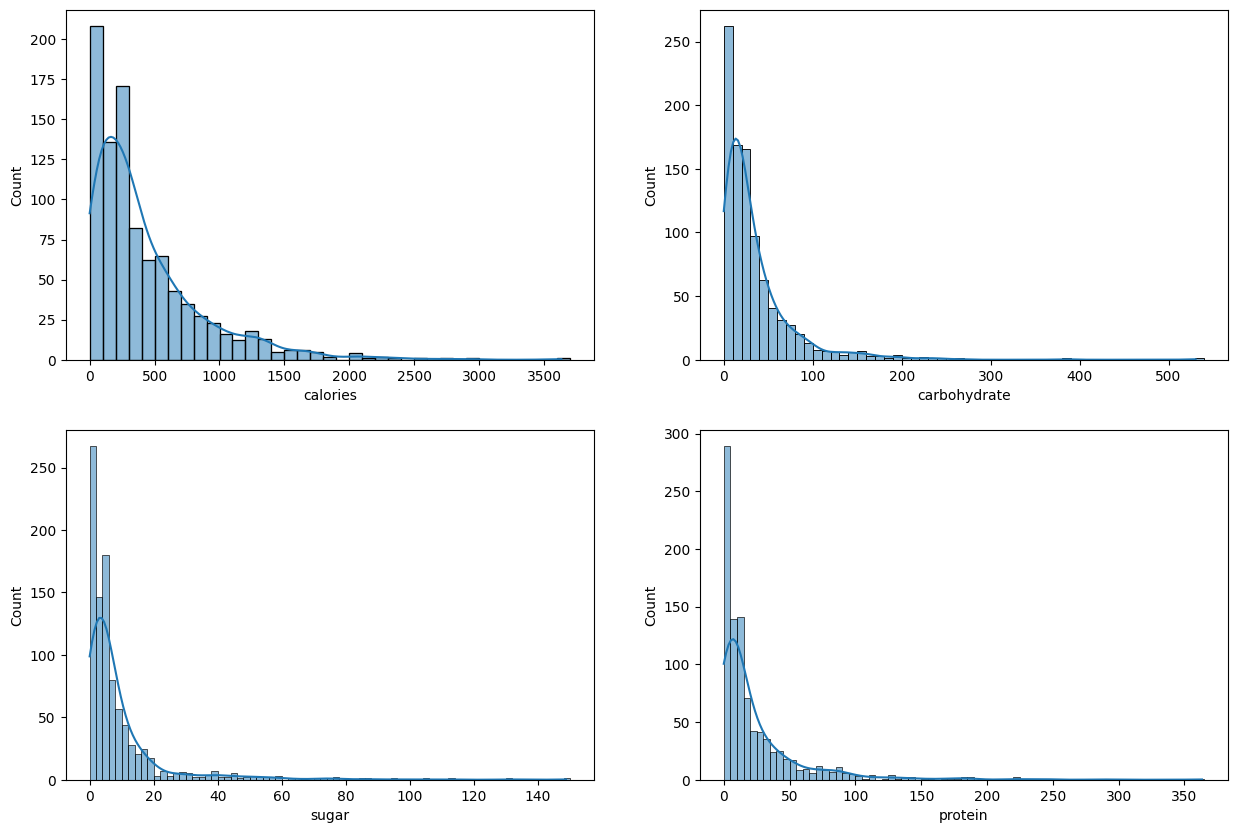

In [29]:
_, ax = plt.subplots(2,2, figsize=(15,10))
sns.histplot(df, x='calories',kde=True, ax=ax[0][0], binwidth=100)
sns.histplot(df, x='carbohydrate',kde=True, ax=ax[0][1], binwidth=10)
sns.histplot(df, x='sugar',kde=True, ax=ax[1][0], binwidth=2)
sns.histplot(df, x='protein',kde=True, ax=ax[1][1], binwidth=5)

<Axes: xlabel='protein'>

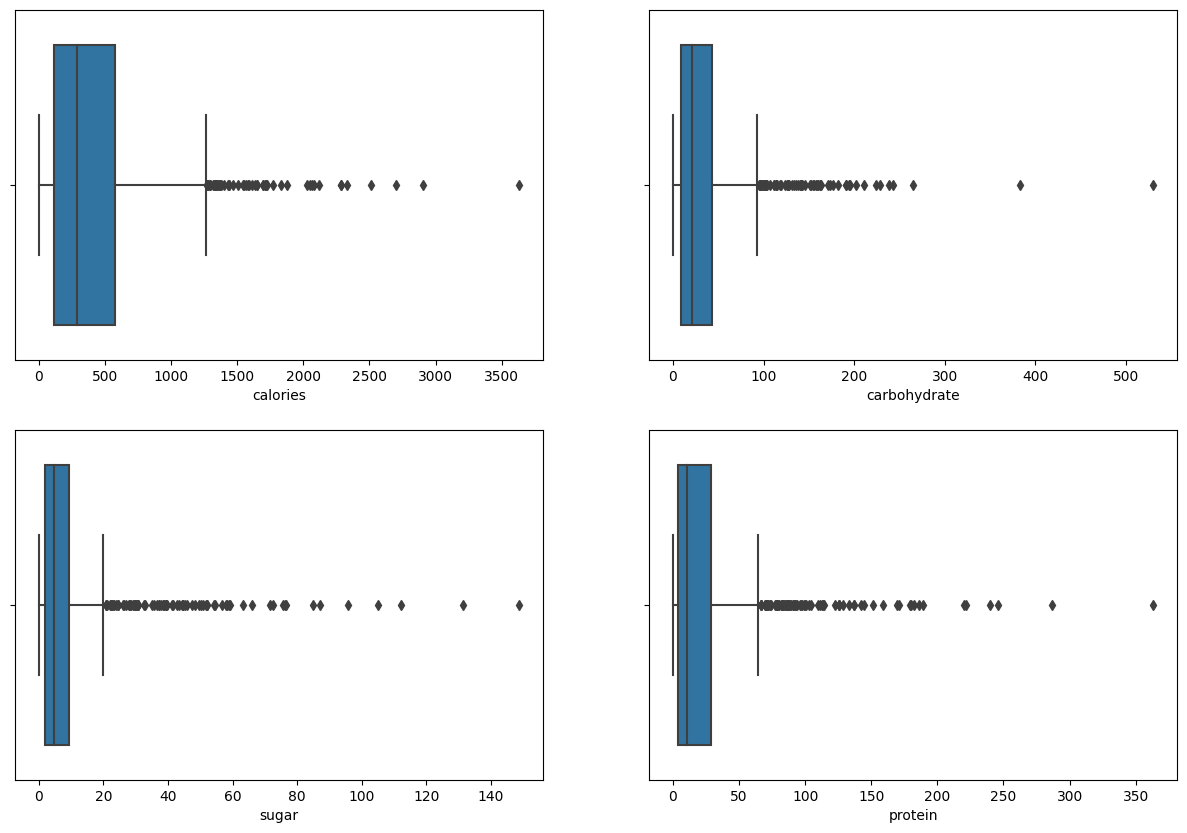

In [30]:
_, ax = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(df, x='calories', ax=ax[0][0])
sns.boxplot(df, x='carbohydrate', ax=ax[0][1])
sns.boxplot(df, x='sugar', ax=ax[1][0])
sns.boxplot(df, x='protein', ax=ax[1][1])

most of our Nutritional Informations is right skewed with a lot of outliers and diffrent scaling, for modeling we need to do some preprocessing on it.

**Insights**:
* **calories**: between 0-500 for most of the recipes with a median of 296 and a maximum of 3633 calories
* **carbohydrate**: between 0-40 for most of the recipes with a median of 21 and a maximum of 530 carbohydrates
* **sugar**: between 0-6 for most of the recipes with a median of 4.4 and a maximum of 148 of sugar
* **protein**: between 0-20 for most of the recipes with a median of 11 and a maximum of 363 protein

<Axes: xlabel='protein', ylabel='high_traffic'>

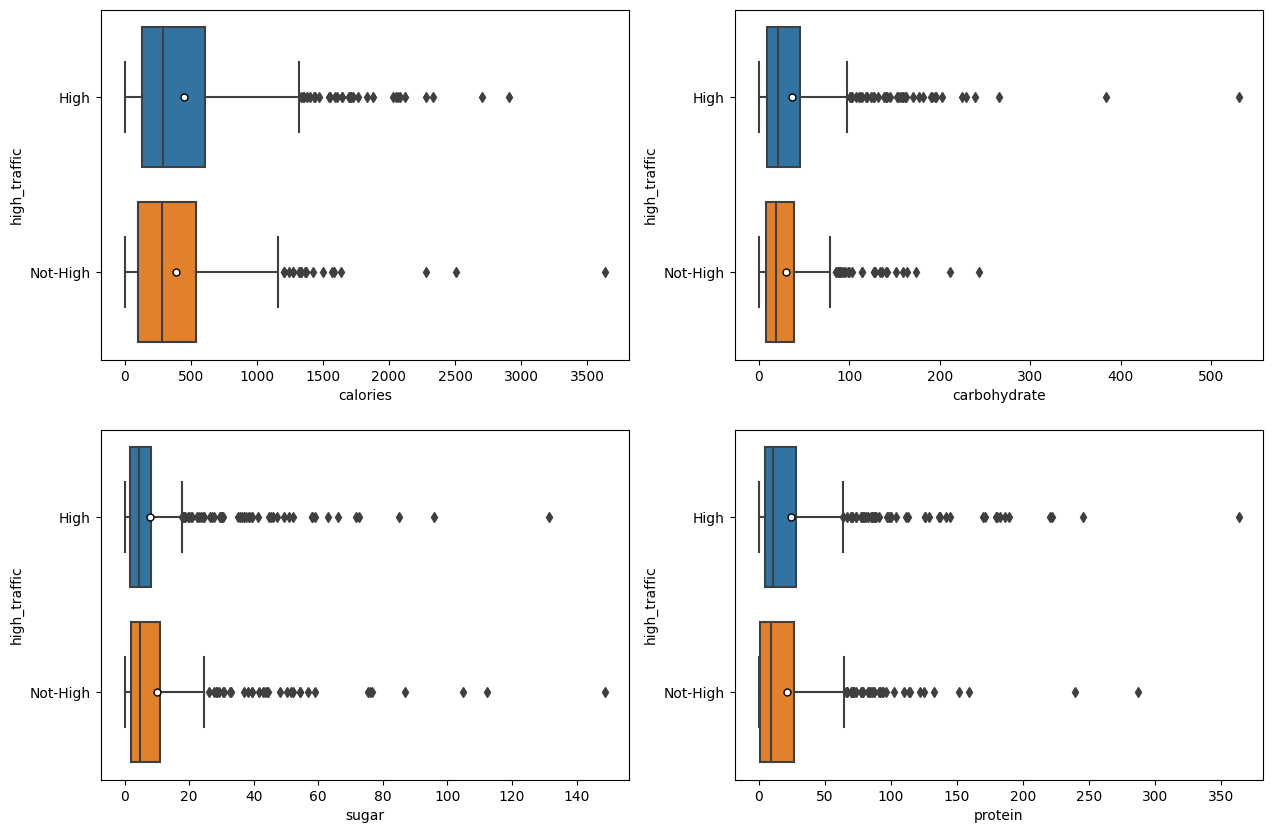

In [31]:
_, ax = plt.subplots(2,2, figsize=(15,10))
meanprops = {"marker":"o",
            "markerfacecolor":"white",
            "markeredgecolor":"black",
            "markersize":"5"}
sns.boxplot(df, x='calories', ax=ax[0][0], y='high_traffic', showmeans=True, meanprops=meanprops)
sns.boxplot(df, x='carbohydrate', ax=ax[0][1], y='high_traffic', showmeans=True, meanprops=meanprops)
sns.boxplot(df, x='sugar', ax=ax[1][0], y='high_traffic', showmeans=True, meanprops=meanprops)
sns.boxplot(df, x='protein', ax=ax[1][1], y='high_traffic', showmeans=True, meanprops=meanprops)

Overall we can see that there is slightly diffrent distribution of the nutitions when compared to the popularity, this means that they have an effect to the target variable
we can also observe, in mean/median a large number of protein, carbohydrate and calories result in higher popularity(high-traffic). This is the contrary for sugar.

It's interesting to perform a hypothsis testing to see if this hypothesis is due to random chance or not

In [32]:
import scipy.stats as stats
for col in ["calories", "carbohydrate", "sugar", "protein"]:
    high_traffic = df.loc[df['high_traffic'] == 'High', col]
    low_traffic = df.loc[df['high_traffic'] == 'Not-High', col]

    _, p_value = stats.ttest_ind(high_traffic, low_traffic)
    print(f"P-value of differences in mean for {col}: {p_value:.4f}")

P-value of differences in mean for calories: 0.0394
P-value of differences in mean for carbohydrate: 0.0235
P-value of differences in mean for sugar: 0.0156
P-value of differences in mean for protein: 0.2522


* **Null Hypothesis (H0):** The null hypothesis typically assumes that there is no significant difference between the means of the two groups.

* **Alternative Hypothesis (H1):** The alternative hypothesis suggests that there is a significant difference between the means of the two groups.

all the p-values are less than 0.05, we can reject all the null hypothesis in fact we have significant difference in mean for the nutritional variables between popular recipes and non-popular recipes except for the protein

**SUMMARY :**

* In our analysis, we've identified the significance of recipe categories in determining popularity. This discovery is valuable for businesses seeking insights into what makes a recipe popular. Notably, categories like vegetables, pork, and potato demonstrate higher traffic. While nutritional factors are relevant.

* On average, recipes with higher levels of calories, protein, and carbohydrates are associated with increased traffic. Additionally, we examined the distributions of these nutritional variables using various visualizations such as boxplots, kernel density estimation (kde) plots, and t-tests. The results indicate only slight differences in means and medians.

* Interestingly, serving size does not appear to be a significant factor based on our graphical analysis. This information provides businesses with a nuanced understanding of recipe features that contribute to popularity, enabling them to make informed decisions.

# Model Development

It's obvious that our problem is a binary classification problem since we need to predict between two categories high-traffic and not-high 

To prevent scaling problem we will perform min max scaler it's not preferred to standardize/nomalize the numerical features since they don't have bell shaped curve as shown before in the graphs

Also it's important to do one-hot encoding or label encoding to categorical features

For this problem, we will use multiple classification models and pick the best 2 of them

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import time

In [34]:
df['high_traffic_binary'] = df['high_traffic'].map({'High': 1, 'Not-High': 0})
df = pd.get_dummies(df, columns=['category'])

In [35]:
X = df.drop(['high_traffic', 'high_traffic_binary'], axis=1)
y = df['high_traffic_binary']

### Dealing with extreme outliers

In [36]:
numerical_columns = ["calories", "carbohydrate", "sugar", "protein"]
Q1 = X[numerical_columns].quantile(0.25)
Q3 = X[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (3 * IQR)
upper_bound = Q3 + (3 * IQR)

def max_value(df, top):
    return np.where(df>top, top, df)

X[numerical_columns] = max_value(X[numerical_columns], upper_bound)

### Splitting & Preprocessing

In [37]:
scaler = MinMaxScaler()

X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modeling

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

In [40]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SCV": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(),
    "SGDC": SGDClassifier(),
    
}

SGDC_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'l1_ratio': [0, 0.15, 0.5, 0.85, 1],
              'max_iter': [1000, 5000, 10000],
            }

lr_grid = {
          'C': [0.01, 0.1, 1, 10, 100],
          'fit_intercept': [True, False],
          'class_weight': [None, 'balanced']
}

svc_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.25],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [4, 8, 12, 16, 20],
    'min_samples_split': [2, 5, 10]
}
knn_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
nb_grid = {
    'var_smoothing': [1e-2, 1e-4, 1e-6, 1e-7, 1e-9, 1e-11]
}

boosting_grid = {
    'max_depth': [4, 8, 12],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15]
}

grid = {
    "Logistic Regression": lr_grid,
    "SCV": svc_grid,
    "Random Forest": rf_grid,
    "KNN": knn_grid,
    "Naive Bayes": nb_grid,
    "XGBoost": boosting_grid,
    "SGDC": SGDC_grid,
}

In [41]:
scores = pd.DataFrame({'Model': models.keys(), 
                       'Accuracy': np.zeros(len(models)),
                       'Training Time': np.zeros(len(models))
                      })
model_best_params = models.copy()
i = 0

for key, model in models.items():
    print('Model: ', key)
    start = time.time()
    
    grid_search = GridSearchCV(estimator=model, param_grid=grid[key], cv=5, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    scores.iloc[i, 1] = grid_search.score(X_test, y_test)
    
    model_best_params[key] = grid_search.best_params_
    
    stop = time.time()
    
    scores.iloc[i, 2] = np.round((stop - start), 2)
    
    print('Model training time(s) : ', scores.iloc[i, 2])
    i += 1

Model:  Logistic Regression
Model training time(s) :  2.97
Model:  SCV
Model training time(s) :  0.52
Model:  Random Forest
Model training time(s) :  17.17
Model:  KNN
Model training time(s) :  0.2
Model:  Naive Bayes
Model training time(s) :  0.15
Model:  XGBoost
Model training time(s) :  4.3
Model:  SGDC
Model training time(s) :  0.62


In [42]:
scores.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Training Time
1,SCV,0.761404,0.52
6,SGDC,0.761404,0.62
4,Naive Bayes,0.750877,0.15
5,XGBoost,0.750877,4.30
0,Logistic Regression,0.740351,2.97
2,Random Forest,0.733333,17.17
3,KNN,0.677193,0.20


let's pick the SVC and LR

In [43]:
lr = LogisticRegression(**model_best_params['Logistic Regression'])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

svm = SVC(**model_best_params['SCV'])
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

## Model evaluation

Here, we present a comparison between the two fitted models. In this scenario, prioritizing precision over accuracy is more appropriate. While accuracy provides an overall assessment of the model's performance, our focus, as per my manager's request, is specifically on studying the "high" label (denoted by 1). Additionally, due to the imperfect balance in my dataset, the utility of accuracy is diminished.

Our objective is to minimize the risk of showcasing unpopular recipes, as indicated in my manager's email. Hence, we aim to avoid False Positive predictions, where an unpopular recipe is incorrectly labeled as popular. Therefore, the precision score is valuable in this context as it considers these instances of False Positive predictions, serving as our primary metric of interest.

While ensuring a decent recall is always beneficial, accounting for False Negatives (popular recipes labeled as unpopular), our main emphasis remains on precision. To strike a balance between precision and recall, we turn to the F1 score, which provides a harmonic mean of these two metrics, offering a comprehensive evaluation.

*****LOGISTIC REGRESSION MODEL*****
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       107
           1       0.78      0.81      0.80       178

    accuracy                           0.74       285
   macro avg       0.72      0.72      0.72       285
weighted avg       0.74      0.74      0.74       285



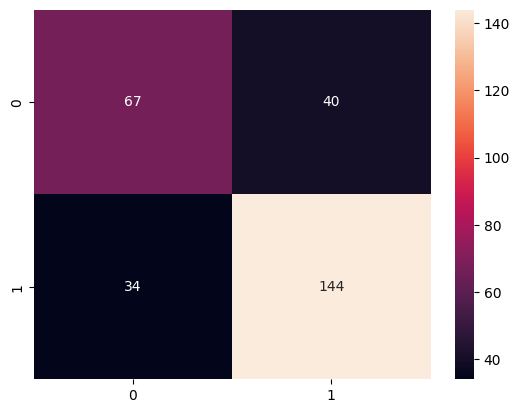

In [44]:
print("*****LOGISTIC REGRESSION MODEL*****")
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt=".0f")
print(classification_report(y_test, y_pred_lr))

*****SVM*****
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       107
           1       0.82      0.80      0.81       178

    accuracy                           0.76       285
   macro avg       0.75      0.75      0.75       285
weighted avg       0.76      0.76      0.76       285



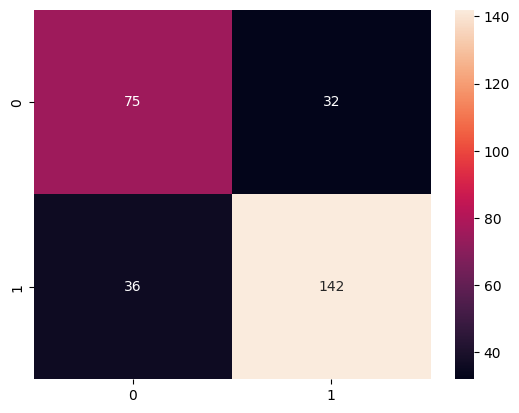

In [45]:
print("*****SVM*****")
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt=".0f")
print(classification_report(y_test, y_pred_svm))